# 🤔 시맨틱 분할이란 ?
---
한 장의 이미지에 포함된 여러 물체의 영역과 이름을 픽셀 수준에서 지정하는 작업을 `시맨틱 분할`이라고 함.

### 시맨틱 분할 프로세스
<p>(1단계) 이미지를 475*475로 리사이즈</p>
<p>(2단계) 이미지를 PSPNet 네트워크에 입력</p>
<p>(3단계) PSPNet 출력이 최댓값인 클랫 ㅡ추출</p>
<p>(4단계) 3단계의 출력(475*475)의 배열을 화상 원 크기로 되돌림</p>

In [1]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import torch.utils.data as data
import torch
import cv2
import numpy as np
import time
import pandas as pd
import os.path as osp
from itertools import product as product
from math import sqrt as sqrt
from PIL import Image
import math

### 이미지 데이터 및 어노테이션 데이터 파일 경로 리스트 작성

In [2]:
def make_datapath_list(rootpath):
    """
    데이터 경로를 저장한 리스트 작성
    Parameters
    ----------
    rootpath : str
        데이터 폴더의 경로
    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로 저장 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 훈련 및 검증 파일 ID 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 훈련 데이터의 화상파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백 및 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id) # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [3]:
rootpath = './pytorch_advanced/semantic_segmentation/data/VOCdevkit/VOC2012/'

In [4]:
# 파일 경로 리스트 작성
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 동작 확인
print(train_img_list[0])
print(train_anno_list[0])

./pytorch_advanced/semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages\2007_000032.jpg
./pytorch_advanced/semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass\2007_000032.png


In [6]:
# 데이터 처리 클래스와 데이터 확장 클래스 import 
from pytorch_advanced.semantic_segmentation.utils.data_augumentation import *

## 데이터셋 작성
---

## DataTransform
- 이미지와 어노테이션을 전처리하는 클래스

In [7]:
class DataTransform() :
    '''
    화상과 어노테이션의 전처리 클래스. 훈련 시와 검증 시 다르게 동작한다.
    화상 크기의 input_size*input_size로 한다.
    훈련 시 데이터 확장을 수행한다.
    
    Attributes
    ----------
    input_size : int
        리사이즈 대상의 화상 크기
    color_mean : (R, G, B)
        각 색상 채널의 평균값
    color_std : (R, G, B)
        각 색상 채널의 표준편차
    '''
    
    def __init__(self, input_size, color_mean, color_std) :
        self.data_transform = {
            'train' : Compose([
                Scale(scale=[0.5, 1.5]), # 이미지 확대
                RandomRotation(angle=[-10, 10]), # 회전
                RandomMirror(), # 랜덤 미러
                Resize(input_size), # 리사이즈
                Normalize_Tensor(color_mean, color_std) # 색상 정보의 표준화 & 텐서화
            ]),
            'val' : Compose([
                Resize(input_size), # 리사이즈
                Normalize_Tensor(color_mean, color_std) # 색상 정보의 표준화 & 텐서화
            ])
        }
        
    def __call__(self, phase, img, anno_class_img) :
        '''
        Parameters
        ----------
        phase : "train" or "val"
        '''
        return self.data_transform[phase](img, anno_class_img)

### VOCDataset
- 데이터셋 클래스

In [8]:
class VOCDataset(data.Dataset) :
    """
    VOC2012의 Dataset을 만드는 클래스. 파이토치의 Dataset 클래스를 상속
    
    Attributes
    ----------
    img_list : 리스트
        이미지 경로를 저장한 리스트
    anno_liist : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스 인스턴스
    """
    
    def __init__(self, img_list, anno_list, phase, transform) :
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        
    def __len__(self) :
        '''이미지의 매수 반환'''
        return len(self.img_list)
    
    def __getitem__(self, index) :
        '''
        전처리한 이미지의 텐서 형식 데이터와 어노테이션을 취득 
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img
    
    def pull_item(self, index) :
        '''
        이미지의 텐서 형식 데이터와 어노테이션을 취득
        '''
        
        # 1. 이미지 읽기
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path) # [높이][폭][색RGB]
        
        # 2. 어노테이션 이미지 읽기
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path) #[높이][폭]
        
        # 3. 전처리 실시
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)
        
        return img, anno_class_img

In [9]:
# 동작 확인

# (RGB) 색 평균치와 표준편차
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# 데이터셋 작성
train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train',
                          transform=DataTransform(input_size=475, color_mean=color_mean,
                                                 color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val',
                        transform=DataTransform(input_size=475, color_mean=color_mean,
                                               color_std=color_std))

# 데이터 추출 예 
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0)[0])

torch.Size([3, 475, 475])
torch.Size([475, 475])
tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.1872,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.1872,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.1872,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3431,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3431,  1.3431],
         [-0.7402, -0.4951, -0.4426,  ...,  1.3957,  1.3431,  1.3431]],

        [[ 2.0474,  1.8905,  1.9428,  ...,  2.1346,  2.0474,  2.082

### DataLoader
- 데이터 로더 작성

In [10]:
# 데이터 로더 작성

batch_size = 8

train_dataloader = data.DataLoader(
                        train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
                        val_dataset, batch_size=batch_size, shuffle=False)

# 사전 오브젝트로 정리
dataloaders_dict = {'train' : train_dataloader, 
                   'val' : val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict['val']) # 반복자로 변환
images, anno_class_images = next(batch_iterator) # 첫 번째 요소를 꺼낸다.
print(images.size()) # torch.Size([8, 3, 475, 475])
print(anno_class_images.size()) # torch.Size([8, 3, 475, 475])

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


## PSPNet 네트워크 구성 및 구현
---
4개의 모듈 (Featrue, Pyramid Pooling, Decoder, AuxLoss)로 구성

In [11]:
class PSPNet(nn.Module) :
    def __init__(self, n_classes) :
        super(PSPNet, self).__init__()
        
        # 파라미터 설정
        block_config = [3, 4, 6, 3] # resnet 50
        img_size =475
        img_size_8 = 60 # img_size의 1/8로 설정
        
        # 네 개의 모듈을 구성하는 서브 네트워크 준비
        self.feature_conv = FeatureMap_convolution()
        
        self.feature_res_1 = ResidualBlockPSP(
                                n_blocks=block_config[0], 
                                in_channels=128,
                                mid_channels=64,
                                out_channels=256,
                                stride=1,
                                dilation=1)
        
        self.feature_res_2 = ResidualBlockPSP(
                                n_blocks=block_config[1],
                                in_channels=256,
                                mid_channels=128,
                                out_channels=512,
                                stride=2,
                                dilation=1)
        
        self.feature_dilated_res_1 = ResidualBlockPSP(
                                    n_blocks=block_config[2],
                                    in_channels=512,
                                    mid_channels=256,
                                    out_channels=1024,
                                    stride=1,
                                    dilation=2)
        
        self.feature_dilated_res_2 = ResidualBlockPSP(
                                        n_blocks=block_config[3],
                                        in_channels=1024,
                                        mid_channels=512,
                                        out_channels=2048,
                                        stride=1,
                                        dilation=4)
        
        self.pyramid_pooling = PyramidPooling(in_channels=2048, 
                                             pool_sizes=[6, 3, 2, 1],
                                             height=img_size_8,
                                             width=img_size_8)
        
        self.decode_feature = DecodePSPFeature(height=img_size,
                                               width=img_size,
                                               n_classes=n_classes)
        
        self.aux = AuxiliaryPSPlayers(in_channels=1024,
                                     height=img_size,
                                     width=img_size,
                                     n_classes=n_classes)
        
    def forward(self, x) :
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)
        
        output_aux = self.aux(x) # Feature 모듈의 중간을 Aux 모듈로
        
        x = self.feature_dilated_res_2(x)
        
        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)
        
        return (output, output_aux)


### Feature 모듈 설명 및 구현(ResNet)
- 다섯개의 서브 네트워크인 `FeatureMap_convolution`, 두 개의 `ResidualBlockPSP`, 두 개의 `dilated ResidualBlockPSP`로 구성됨

#### FeatureMap_convolution
- 서브 네트워크 구현

In [12]:
class conv2DBatchNormRelu(nn.Module) :
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,
               dilation, bias) :
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                             padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplace 설정 : 입력 저장하지 않고 출력을 계산하여 메모리를 절약함
        
    def forward(self, x) :
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)
        
        return outputs

In [13]:
class FeatureMap_convolution(nn.Module) :
    def __init__(self) :
        '''구성할 네트워크 준비'''
        super(FeatureMap_convolution, self).__init__()
        
        # 합성곱 층 1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)
        
        # 합성곱 층 2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)
        
        # 합성곱 층 3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)
        
        # 최대 풀링 층
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
    def forward(self, x) :
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs

#### ResidualBlockPSP
- 서브 네트워크 구현

In [14]:
class ResidualBlockPSP(nn.Sequential) :
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation) :
        super(ResidualBlockPSP, self).__init__()
        
        # bottleNeckPSP 준비
        self.add_module('block1',
                       bottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation))
        
        # bottleNeckIdentifyPSP 반복 준비
        for i in range(n_blocks - 1) :
            self.add_module('block' + str(i+2),
                           bottleNeckIdentifyPSP(out_channels,
                                            mid_channels,
                                            stride, dilation))

- bottleNeckPSP와 bottleNeckIdentifyPSP 구현

In [15]:
class conv2DBatchNorm(nn.Module) :
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,
                dilation, bias) :
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                              dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        
    def forward(self, x) :
        x = self.conv(x)
        outputs = self.batchnorm(x)
        return outputs

In [16]:
class bottleNeckPSP(nn.Module) :
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation) :
        super(bottleNeckPSP, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(in_channels,
                                        mid_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0,
                                        dilation=1,
                                        bias=False)
        self.cbr_2 = conv2DBatchNormRelu(mid_channels,
                                        mid_channels,
                                        kernel_size=3,
                                        stride=stride,
                                        padding=dilation,
                                         dilation=dilation,
                                         bias=False
                                        )
        self.cb_3 = conv2DBatchNorm(mid_channels,
                                   out_channels,
                                   kernel_size=1,
                                   stride=1,
                                   padding=0,
                                   dilation=1,
                                   bias=False)
        
        self.cb_residual = conv2DBatchNorm(in_channels, out_channels,
                                          kernel_size=1, stride=stride,
                                          padding=0, dilation=1,
                                          bias=False)
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x) :
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)

In [17]:
class bottleNeckIdentifyPSP(nn.Module) :
    def __init__(self, in_channels, mid_channels, stride, dilation) :
        super(bottleNeckIdentifyPSP, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(in_channels,
                                        mid_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0,
                                        dilation=1,
                                        bias=False)
        self.cbr_2 = conv2DBatchNormRelu(mid_channels,
                                        mid_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=dilation,
                                        dilation=dilation,
                                        bias=False)
        self.cb_3 = conv2DBatchNorm(mid_channels,
                                   in_channels,
                                   kernel_size=1,
                                   stride=1,
                                   padding=0,
                                   dilation=1,
                                   bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x) :
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)

#### Pyramid Pooling 
- 서브 네트워크 구현

In [18]:
class PyramidPooling(nn.Module) :
    def __init__(self, in_channels, pool_sizes, height, width) :
        super(PyramidPooling, self).__init__()
        
        # forward에서 사용하는 화상 크기
        self.height = height
        self.width = width
        
        # 각 합성곱 층의 출력 채널 수
        out_channels = int(in_channels / len(pool_sizes))
        
        # 각 합성곱 층 작성
        # 다음은 for문으로 구현하는 것이 좋지만 이해를 돕기 위해 상세하게 작성한다.
        # pool_sizes : [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(in_channels, out_channels,
                                        kernel_size=1, stride=1,
                                        padding=0, dilation=1, bias=False)
        
        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(in_channels, out_channels,
                                        kernel_size=1, stride=1,
                                        padding=0, dilation=1, bias=False)
        
        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(in_channels, out_channels,
                                        kernel_size=1, stride=1, padding=0,
                                        dilation=1, bias=False)
        
        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size=1,
                                        stride=1, padding=0, dilation=1, bias=False)
        
    def forward(self, x) :
        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(self.height, self.width), mode='bilinear', align_corners=True)
        
        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(self.height, self.width), mode='bilinear', align_corners=True)
        
        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(self.height, self.width), mode='bilinear', align_corners=True)
        
        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(self.height, self.width), mode='bilinear', align_corners=True)
        
        # 최종 결합시킬 dim=1으로 채널 수 차원에서 결합
        output = torch.cat([x, out1, out2, out3, out4], dim=1)
        
        return output

#### Decoder, Auxloss 모듈 구현

In [19]:
class DecodePSPFeature(nn.Module) :
    def __init__(self, height, width, n_classes) :
        super(DecodePSPFeature, self).__init__()
        
        # forward에 사용하는 이미지 크기
        self.height=height
        self.width=width
        
        self.cbr = conv2DBatchNormRelu(in_channels=4096,
                                      out_channels=512,
                                      kernel_size=3,
                                      stride=1,
                                      padding=1,
                                      dilation=1,
                                      bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(in_channels=512, out_channels=n_classes,
                                       kernel_size=1, stride=1, padding=0)
        
    def forward(self, x) :
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(x, size=(self.height, self.width), mode='bilinear',
                              align_corners=True)
        
        return output

In [20]:
class AuxiliaryPSPlayers(nn.Module) :
    def __init__(self, in_channels, height, width, n_classes) :
        super(AuxiliaryPSPlayers, self).__init__()
        
        # forward에 사용하는 화상 크기
        self.height= height
        self.width = width
        
        self.cbr = conv2DBatchNormRelu(in_channels=in_channels, out_channels=256,
                                      kernel_size=3, stride=1, padding=1, dilation=1,
                                      bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(in_channels=256, out_channels=n_classes,
                                       kernel_size=1, stride=1, padding=0)
        
    def forward(self, x) :
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(x, size=(self.height, self.width), 
                              mode='bilinear', align_corners=True)
        return output

In [21]:
# 모델 정의
net = PSPNet(n_classes=21)
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNeckPSP(
      (cb

In [31]:
# 더미 데이터 작성
batch_size = 2
dummy_img = torch.rand(batch_size,3, 475, 475)

# 계산
outputs = net(dummy_img)
print(outputs)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:62] data. DefaultCPUAllocator: not enough memory: you tried to allocate %dGB. Buy new RAM!0


## 파인튜닝을 활용한 학습 및 검증 실시(PSPNet)
---

## 학습 및 검증 구현

In [ ]:
# file path
rootpath = './pytorch_advanced/semantic_segmentation/data/VOCdevkit/VOC2012/'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath=rootpath)

# 데이터셋 작성
# RGB 색의 평균값과 표준편차
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train',
                          transform=DataTransform(input_size=475,
                                                 color_mean=color_mean,
                                                 color_std=color_std))
val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val',
                         transform=DataTransform(input_size=475,
                                                color_mean=color_mean,
                                                color_std=color_std))

# 데이터 로더 작성
batch_size = 8
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수로 정리
dataloaders_dict = {'train' : train_dataloader , 
                   'val' : val_dataloader}

In [ ]:
# 파인튜닝으로 PSPNet 작성
# ADE20K 데이터셋의 학습된 모델을 사용하여 ADE20K 클래스 수는 150
net = PSPNet(n_classes=150)

In [ ]:
# ADE20K 학습된 파라미터 읽기
state_dict = torch.load('./pytorch_advanced/semantic_segmentation/weights/pspnet50_ADE20K.pth', map_location='cpu')
net.load_state_dict(state_dict)

# 분류용 합성곱 층을 출력 수 21로 변경
n_classes = 21
net.decode_feature.classification = nn.Conv2d(in_channels=512, out_channels=n_classes,
                                             kernel_size=1, stride=1, padding=0)
net.aux.classification = nn.Conv2d(in_channels=256, out_channels=n_classes,
                                  kernel_size=1, stride=1, padding=0)

# 교체한 합성곱 층 초기화
def weights_init(m) :
    if isinstance(m, nn.Conv2d) :
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None : # 바이어스 항이 있는 경우
            nn.init.constant_(m.bias, 0.0)

net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)

print('네트워크 설정 완료! 학습된 가중치를 로드했습니다.')

In [ ]:
# 손실함수 정의
class PSPLoss(nn.Module) :
    '''PSPNet 손실함수 클래스입니다'''
    def __init__(self, aux_weight=0.4) :
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight # aux_loss의 가중치
        
    def forward(self, outputs, targets) :
        '''
        손실함수 계산
        
        Parameters
        ----------
        outputs : PSPNet 출력(tuple)
        (output=torch.Size([num_batch, 21, 475, 475]), 
        output_aux=torch.Size([num_batch, 21, 475, 475]))
        
        targets : [num_batch, 475, 457]
            정답 어노테이션 정보
            
        Returns
        -------
        loss : 텐서
            손실 값'''

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')
        
        return loss+self.aux_weight*loss_aux

criterion = PSPLoss(aux_weight = 0.4)

- 스케줄러로 에폭별 학습 비율을 변경

In [ ]:
# 파인튜닝이므로 학습률을 작게
optimizer = optim.SGD([
    {'params' : net.feature_conv.parameters(), 'lr' : 1e-3},
    {'params' : net.feature_res_1.parameters(), 'lr' : 1e-3},
    {'params' : net.feature_res_2.parameters(), 'lr' : 1e-3},
    {'params' : net.feature_dilated_res_1.parameters(), 'lr' : 1e-3},
    {'params' : net.feature_dilated_res_2.parameters(), 'lr' : 1e-3},
    {'params' : net.pyramid_pooling.parameters(), 'lr' : 1e-3},
    {'params' : net.decode_feature.parameters(), 'lr' : 1e-2},
    {'params' : net.aux.parameters(), 'lr' : 1e-2}],
    momentum=0.9, weight_decay=0.0001)
    
# 스케줄러 설정
def lambda_epoch(epoch) :
    max_epoch = 30
    return math.pow((1-epoch/max_epoch), 0.9)


scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [ ]:
# 모델 학습 함수 작성
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs) :
    
    # GPU를 사용할 수 있는지 확인
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'사용 장치 : {device}')
    
    # network를 gpu로(또는 cpu)
    net.to(device)
    
    # 네트워크가 어느정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True
    
    # 이미지 매수
    num_train_imgs = len(dataloaders_dict['train'].dataset)
    num_val_imgs = len(dataloaders_dict['val'].dataset)
    batch_size = dataloaders_dict['train'].batch_size
    
    # 반복자의 카운터 설정
    iteration = 1
    logs = []
    
    # 멀티플 미니 배치
    batch_multiplier = 3
    
    # epoch loop
    for epoch in range(num_epochs) :
        # 시작시간 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss= 0.0 # 에폭 손실의 합
        epoch_val_loss = 0.0 # 에폭 손실의 합
        
        print('-'*20)
        print(f'Epoch {epoch +1}/{num_epochs}')
        print('-'*20)        
        
        # 에폭별 훈련 및 검증 루프
        for phase in ['train', 'val'] :
            if phase == 'train' :
                net.train() # 모델을 훈련 모드로
                scheduler.step() # 최적화 스케줄러 갱신
                optimizer.zero_grad()
                print('(train)')
                
            else :
                if ((epoch+1)%5 == 0) :
                    net.eval() # 모델을 검증 모드로
                    print('-') * 20
                    print('(val)')
                    
                else :
                    # 검증은 5번 중 1번만 수행
                    continue
                    
            # 데이터 로더에서 미니 배치씩 꺼내 루프
            count = 0 # 멀티플 미니배치
            for images, anno_class_images in dataloaders_dict[phase] :
                # 미니 배치 크기가 1이면 배치 정규화에서 오류가 발생하여 피함
                if images.size()[0] == 1 :
                    continue
                    
                # GPU를 사용할 수 있으면 GPU에 데이터를 보낸다.
                images = images.to(device)
                anno_class_images = anno_class_images.to(device)
                
                # 멀티플 미니배치로 파라미터 갱신
                if (phase == 'train') and (count == 0) :
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train') :
                    outputs = net(images)
                    loss = criterion(outputs, anno_class_images.long() / batch_multiplier)
                    
                    # 훈련 시에는 역전파
                    if phase == 'train' :
                        loss.backward() # 경사 계산
                        count -= 1 # 멀티플 미니 배치
                        
                        if (iteration % 10 == 0 ) : # 10iter에 한번 손실 표시
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print(f'반복 {iteration} || Loss :  \
                                  {loss.item()/batch_size*batch_multiplier:.4f} || 10 iter : {duration:.4f} sec.')
                            
                            epoch_train_loss += loss.item() * batch_multiplier
                            iteration += 1
                                  
                    # 검증 시
                    else :
                        epoch_val_loss += loss.item() * batch_multiplier
    
        # 에폭의 phase별 손실과 정답률
        t_epoch_finish = time.time()
        print('-') * 50
        print(f'epoch {epoch+1} || Epoch_TRAIN_Loss:{epoch_train_loss/num_train_imgs:.4f} \
        || Epoch_VAL_Loss :{epoch_val_loss/num_val_imgs:.4f}')
        print(f'timer : {t_epoch_finish - t_epoch_start:.4f} sec')  

        # 로그 저장
        log_epoch = {'epoch' : epoch+1, 'tain_loss' : epoch_train_loss/num_train_imgs,
                    'val_loss' : epoch_val_loss/num_val_imgs}

        los.append(log_epoch)

        df = pd.DataFrame(logs)
        df.to_csv('log_output.csv')
    
    # 마지막 네트워크 저장
    torch.save(net.state_dict(), './pytorch_advanced/semantic_segmentation/weights/pspnet50_' + str(epoch+1) +'.pth')

In [ ]:
# 학습 및 검증 실행
num_epochs = 30
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs)

---
# 시맨틱 분할 추론

In [24]:
# 학습된 파라미터 읽기
state_dict = torch.load('./pytorch_advanced/semantic_segmentation/weights/pspnet50_30.pth',
                       map_location='cpu')
net.load_state_dict(state_dict)
print('네트워크 설정 완료 ! 학습된 가중치를 로드했습니다.')

네트워크 설정 완료 ! 학습된 가중치를 로드했습니다.


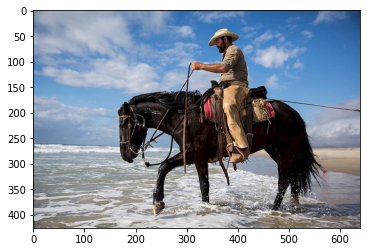

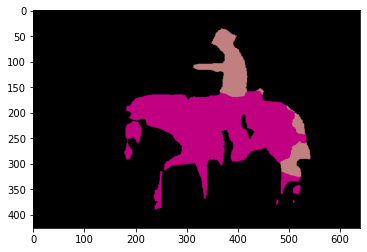

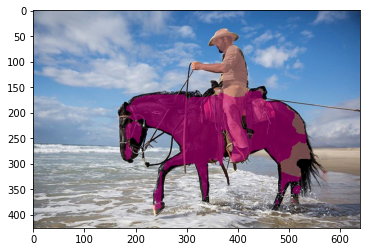

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
# 1. 원본 화상 표시
image_file_path = './pytorch_advanced/semantic_segmentation/data/cowboy-757575_640.jpg'
img = Image.open(image_file_path) 
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 전처리 클래스 작성
color_mean = (0.485, 0.456, 0.456)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(input_size=475, color_mean=color_mean,
                         color_std=color_std)

# 3. 전처리
# 적당한 어노테이션 이미지를 준비하여 색상 파레트 정보 추출
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)
p_palette = anno_class_img.getpalette()
phase = 'val'
img, anno_class_img = transform(phase, img, anno_class_img)

# 4. PSPNet으로 추론
net.eval()
x = img.unsqueeze(0) # 미니배치화 : torch.Size([[1, 3, 475, 475]])
outputs = net(x)
y = outputs[0] # AuxLoss측은 무시, y의 크기는 torch.Size([1, 21, 475, 475])

# 5. PSPNet 출력으로 최대 클래스를 구하여 색상 팔레트 형식으로 
# 화상 크기를 원래대로 되돌린다
y = y[0].detach().numpy() # y : torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 6. 화상을 투과시켜 겹친다
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA') # 색상 팔레트 형식을 RGBA로 변환

for x in range(img_width) :
    for y in range(img_height) :
        # 추론 결과 화상의 픽셀 데이터를 취득
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a =pixel
        
        # (0, 0, 0)의 배경이라면 그대로 투과
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0 :
            continue
        else :
            # 그 외 색상은 준비된 화상에 픽셀 기록
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 투과율 150으로 지정
img = Image.open(image_file_path)
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()

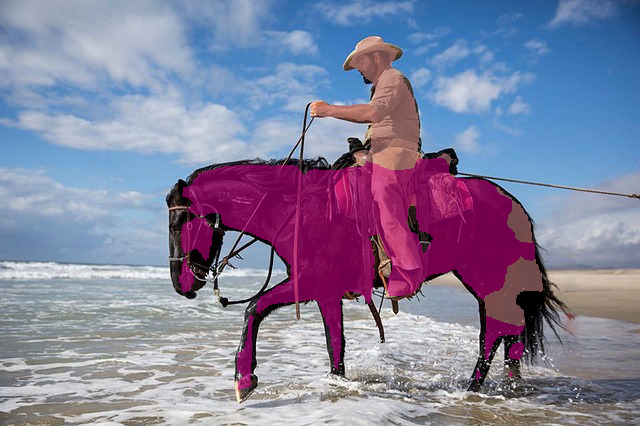

In [32]:
result # 추론 결과 오버랩